# Fast BLS demonstration

This page demonstrates the functionality of GERBLS by applying a fast-folding BLS to a simulated data set. First, we set up the necessary imports:

In [1]:
import gerbls
import matplotlib.pyplot as plt
import numpy as np

The data set we are using is included in the GERBLS source distribution as [tests/phottest.dat](https://github.com/kment/GERBLS/blob/main/tests/phottest.dat). It includes a simulated transit with a period of 1.37 days. In order to run GERBLS, we need to store the data in a [gerbls.pyDataContainer](../api/struct.rst#gerbls.pyDataContainer) object.

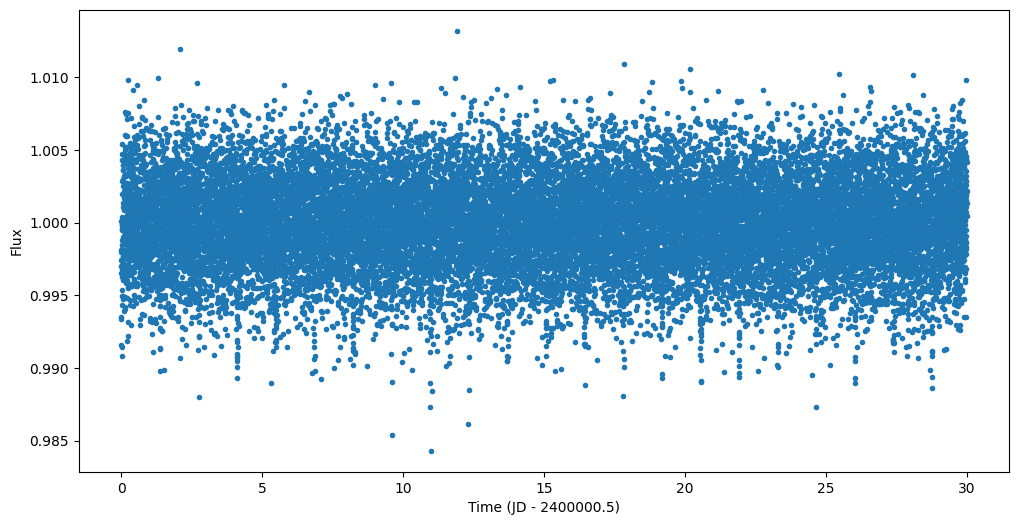

In [2]:
phottest = np.loadtxt("../../../tests/phottest.dat")
time, mag, err = phottest.T

data = gerbls.pyDataContainer()
data.store(time, mag, err)

plt.figure(figsize=(12, 6))
plt.plot(data.rjd - 2400000.5, data.mag, ".")
plt.xlabel("Time (JD - 2400000.5)")
plt.ylabel("Flux")
plt.show()

It should be noted that any long-term trends in the data (due to stellar variability, instrument systematics, etc.) should be subtracted from the data via detrending before running the BLS. GERBLS provides a wrapper on a Savitsky-Golay filter via [gerbls.clean_savgol()](../api/clean.rst#gerbls.clean_savgol), which can handle basic long-term variability; however, more complex detrenders may be required for some data sets. In this example data set, there is no long-term stellar variability, so we shall just use `data` as our detrended data.

Next, we can set up the fast-folding BLS.

In [3]:
min_period = 0.4    # Minimum searched orbital period (in days)
max_period = 10.    # Maximum searched orbital period (in days)
t_samp = 10./60/24  # Desired time sampling of the data
dur = 1./24         # Searched transit duration

bls = gerbls.pyFastBLS()
bls.setup(data,
          min_period,
          max_period,
          t_samp=t_samp,
          duration_mode='constant',
          min_duration_factor=dur,
          max_duration_factor=dur)

The time sampling (`t_samp`) is a key parameter of the fast-folding BLS. Before running the BLS, the data is resampled to the specified time cadence (here, 10 minutes). A shorter sampling time increases the BLS precision as well as the number of periods searched, but it also makes the BLS run slower. Thus, when speed is important, `t_samp` can be cautiously increased as long as its value remains substantially below the expected duration of the transits. If not given (`t_samp` is an optional parameter), its value is set to the median time cadence of the input data. In this example, we are also fitting for a single transit duration (`dur`, equal to 1 hour) at each tested period.

We can now generate the BLS spectrum, saving the results in double precision to be safe.

In [4]:
bls.run_double(verbose=True)

Starting FFA...
Downsampling: OFF
Number of tested periods: 16595
BLS runtime: 0.056743 sec


The number of tested periods was 16,595; this can be affected by changing `t_samp` or the range of searched orbital periods. In order to process the results of the BLS analysis, we create an instance of [gerbls.pyBLSAnalyzer](../api/blsresult.rst#gerbls.pyBLSAnalyzer), which allows us to easily retrieve the $\Delta\chi^2$ values (difference in $\chi^2$ between a fitted box model and a constant-flux model with no transit) as well as other fitted parameters at each tested orbital period.

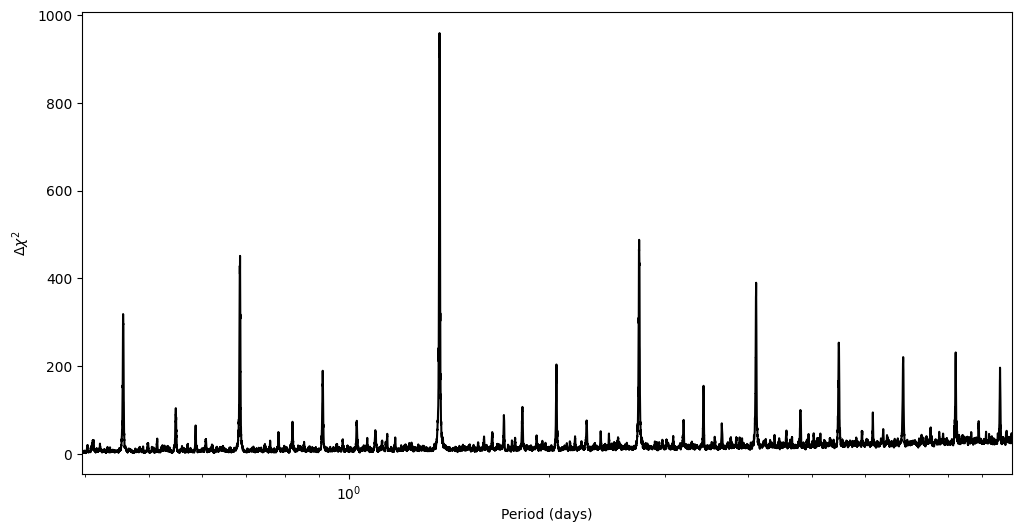

In [5]:
blsa = gerbls.pyBLSAnalyzer(bls)

plt.figure(figsize=(12, 6))
plt.semilogx(blsa.P, -blsa.dchi2, "k-")
plt.xlim(blsa.P.min(), blsa.P.max())
plt.xlabel("Period (days)")
plt.ylabel("$\Delta\chi^2$")
plt.show()

There is a clear peak close to a period of 1.4 days, corresponding to the transits in the data. [gerbls.pyBLSAnalyzer](../api/blsresult.rst#gerbls.pyBLSAnalyzer) provides a method called [generate_models(N)](../api/blsresult.rst#gerbls.pyBLSAnalyzer.generate_models), which returns the parameters of the top $N$ peaks in the BLS spectrum. Below, we just retrieve the box model corresponding to the highest BLS peak and overlay it on top of the original data phase folded to the detected orbital period.

pyBLSResult(P=1.3697938726528307, dchi2=-958.8683823300646, mag0=1.0000391865777314, dmag=0.0036689615704791514, t0=1.1019297968341242, dur=0.041666666666666664, snr=30.965599983369682)


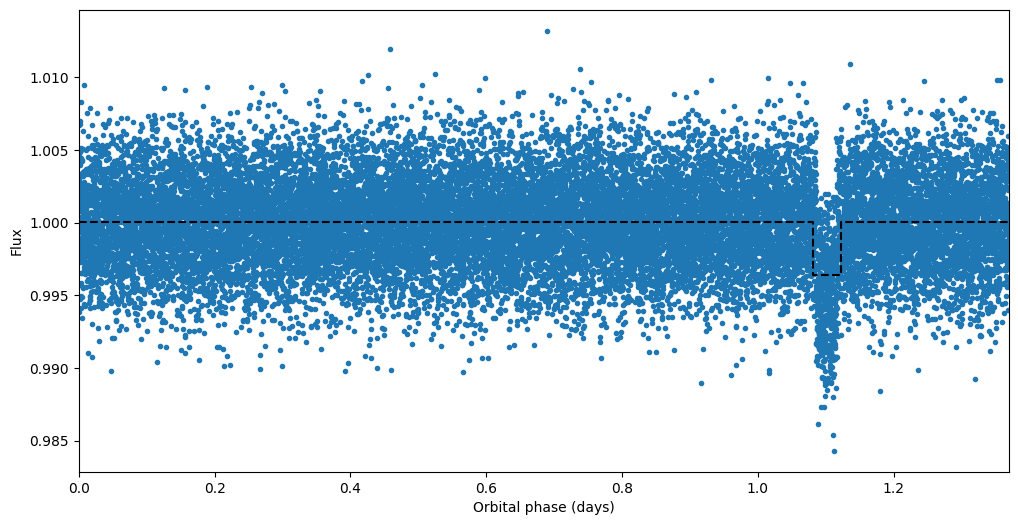

In [6]:
model = blsa.generate_models(1)[0]

# Print information about the top BLS peak
print(model)

# Arrays to overlay the best-fit box model
fit_x = [0, model.t0 - model.dur / 2, model.t0 - model.dur / 2,
         model.t0 + model.dur / 2, model.t0 + model.dur / 2, model.P]
fit_y = np.array([0, 0, -model.dmag, -model.dmag, 0, 0]) + model.mag0

plt.figure(figsize=(12, 6))
plt.plot(data.rjd % model.P, data.mag, ".")
plt.plot(fit_x, fit_y, "k--")
plt.xlim(0, model.P)
plt.xlabel("Orbital phase (days)")
plt.ylabel("Flux")
plt.show()

It is a clear match! Note that our searched transit duration (1 hour) was slightly longer than the actual transits in the data. This has the effect of diluting the fitted transit depth - instead of 0.5%, the recovered depth is close to 0.37%. This can be fixed by searching a range of transit durations at each period, as opposed to a single fixed value.

In [7]:
print(f"Fitted transit depth: {model.dmag:.5f} +/- {model.get_dmag_err(data):.5f}")
print(f"SNR: {model.get_SNR(data):.4f}")

Fitted transit depth: 0.00367 +/- 0.00012
SNR: 30.8295
